# Sentiment Analysis
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface

# Step 0. Read in Data and NLTK Basics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
# Read in data
df = pd.read_pickle('./merged_clean.pkl')
print(df.shape)

(374265, 8)


In [5]:
df.head()

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...


## Quick EDA

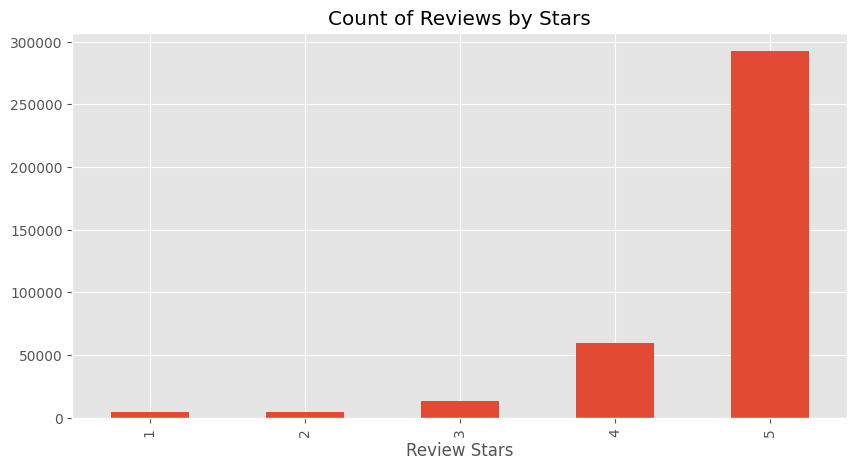

In [6]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [7]:
example = df['reviews'][50]
print(example)

It was very useful course. This course is very time taking but the best and worth fullBut I'm not getting course certificate


In [8]:
nltk.download('punkt_tab')
tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt_tab to /home/asish/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['It', 'was', 'very', 'useful', 'course', '.', 'This', 'course', 'is', 'very']

In [9]:
nltk.download('averaged_perceptron_tagger_eng')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/asish/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


[('It', 'PRP'),
 ('was', 'VBD'),
 ('very', 'RB'),
 ('useful', 'JJ'),
 ('course', 'NN'),
 ('.', '.'),
 ('This', 'DT'),
 ('course', 'NN'),
 ('is', 'VBZ'),
 ('very', 'RB')]

In [10]:
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /home/asish/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /home/asish/nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  It/PRP
  was/VBD
  very/RB
  useful/JJ
  course/NN
  ./.
  This/DT
  course/NN
  is/VBZ
  very/RB
  time/NN
  taking/VBG
  but/CC
  the/DT
  best/JJS
  and/CC
  worth/JJ
  fullBut/NN
  I/PRP
  'm/VBP
  not/RB
  getting/VBG
  course/NN
  certificate/NN)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/asish/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [13]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [14]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.65, 'pos': 0.35, 'compound': 0.8819}

In [15]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['reviews']
    myid = i
    res[myid] = sia.polarity_scores(text)

100%|██████████| 374265/374265 [01:15<00:00, 4964.30it/s]


In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.join(df)

## Plot VADER results

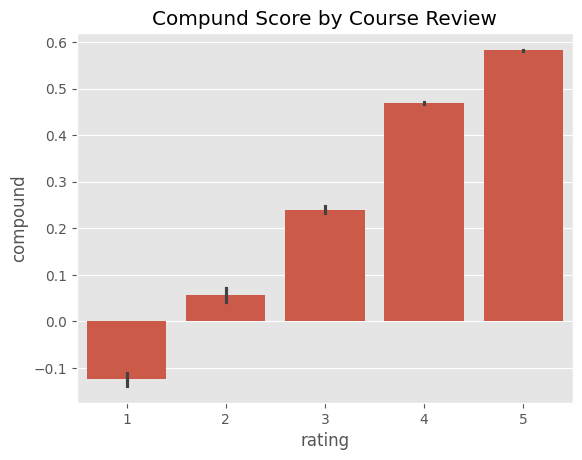

In [17]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Course Review')
plt.show()

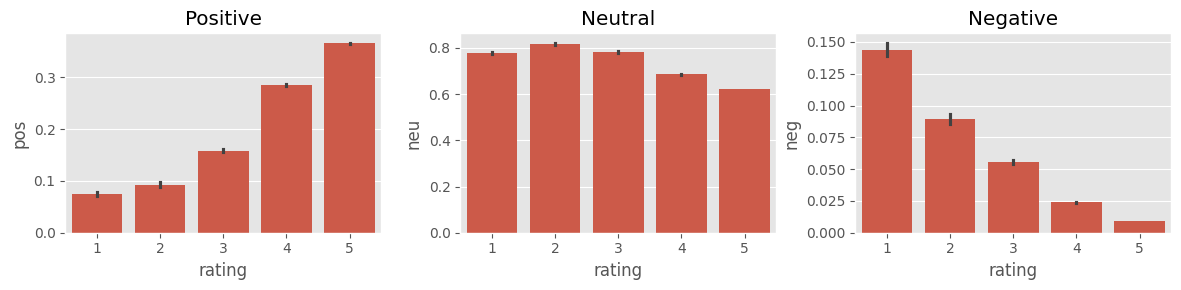

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [21]:
# VADER results on example
print(example)
sia.polarity_scores(example)

It was very useful course. This course is very time taking but the best and worth fullBut I'm not getting course certificate


{'neg': 0.0, 'neu': 0.65, 'pos': 0.35, 'compound': 0.8819}

In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512)
    try:
        output = model(**encoded_text)
    except IndexError as e:
        print(f"Error processing input: {e}")
        # Return a default value or handle the error as needed
        return {"error": "index_error", "details": str(e)}
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
df = df[:100000]
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['reviews']
        myid = i
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  6%|▌         | 6223/100000 [07:39<2:58:32,  8.75it/s]

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.join(df)

## Compare Scores between models

In [ ]:
results_df.columns

# Step 3. Combine and compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews


In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]